In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [2]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

# Getting and Cleaning Data

We clean the data of NaN values by simply replacing each NaN value with the mean value of number of visits for each sample.

In [3]:
# Get the time series data.
data_df = pd.read_csv('train_2.csv')

print('data_df.shape = ', data_df.shape)
data_df.head()

data_df.shape =  (145063, 794)


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


In [4]:
# Now fix NaN values in data_df.

means = data_df.drop('Page', axis = 1).mean(axis = 1)
means.fillna(0, inplace = True)

for column in data_df.columns:
    
    data_df[column].fillna(means, inplace = True)

data_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,17.0,...,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0


# Divide Data into Training and Validation

In [5]:
timeSeries = data_df.drop(['Page'], axis = 1).values

In [6]:
# Now get data for training and validation.
futureT = 62

X_all = timeSeries[:, :-futureT]
Y_all = timeSeries[:, -futureT:]

In [7]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
print('X_train.shape = ', X_train.shape, '\tY_train.shape = ', Y_train.shape, 
      '\tX_valid.shape = ', X_valid.shape, '\tY_valid.shape = ', Y_valid.shape)

X_train.shape =  (97192, 731) 	Y_train.shape =  (97192, 62) 	X_valid.shape =  (47871, 731) 	Y_valid.shape =  (47871, 62)


In [8]:
# Now let's set up a data frame to investigate the correlation between the Y_mean and the X_mean.

X_train_m = X_train.mean(axis = 1, keepdims = True)
Y_train_m = Y_train.mean(axis = 1, keepdims = True)

In [9]:
# Let's look at benchmark of average.
epsilon = 1e-6

X_mean = X_train.mean(axis = 1, keepdims = True)
Y_predict = np.full(Y_train.shape, X_mean)
result = smape(epsilon + Y_predict, Y_train)
print('smape = ', result)

smape =  77.5045731276


1 ,6 ,11 ,16 ,21 ,26 ,31 ,36 ,41 ,46 ,51 ,56 ,61 ,66 ,71 ,76 ,81 ,86 ,91 ,96 ,

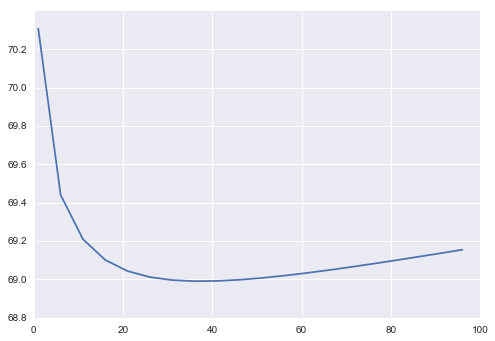

In [10]:
# Let's decide on parameter for log transform.

nSample, nTimes = X_train.shape

epsilon = 1e-6
search = np.arange(1, 100, 5)

results = []
for var in search:
    Z_train = np.log(var + X_train)
    Z_mean = Z_train.mean(axis = 1, keepdims = True)
    Y_predict = np.full((Y_train.shape), -var + np.exp(Z_mean))
    result = smape(epsilon + Y_predict, Y_train)
    results.append(result)
    print(var, ',', end = '')
    
plt.plot(search, results)
plt.show()

In [11]:
param = 30
X_train_lm = np.log(param + X_train).mean(axis = 1, keepdims = True)
Y_train_lm = np.log(param + Y_train).mean(axis = 1, keepdims = True)
means_df = pd.DataFrame(np.concatenate((X_train_lm, Y_train_lm), axis = 1), columns = ['X_train_lm', 'Y_train_lm'])

means_df.head()

,X_train_lm,Y_train_lm
0,4.543886,4.407597
1,4.581753,4.395935
2,3.764482,4.219276
3,7.689277,7.360345
4,4.747078,4.577913


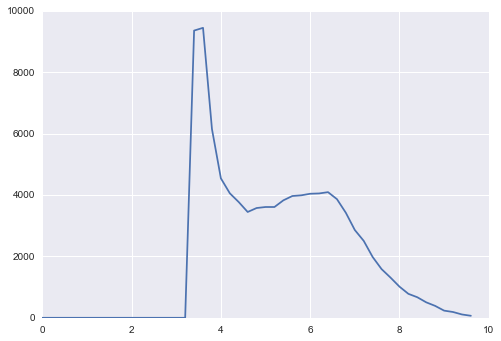

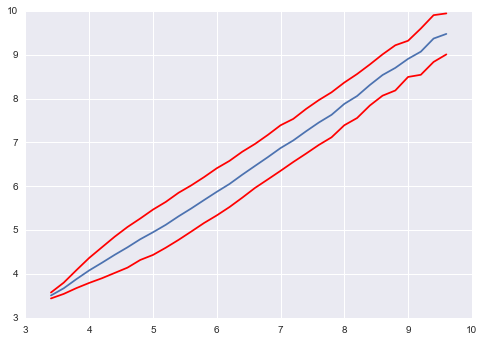

In [12]:
# Let's get a histogram of Y_train_m vs X_train_m.

bins = np.arange(0, 10, 10 / 50)
cut = pd.cut(means_df.X_train_lm, bins = bins)

counts = means_df.groupby(cut).count().Y_train_lm
plt.plot(bins[:-1], counts)
plt.show()

means =  means_df.groupby(cut).mean().Y_train_lm
std = means_df.groupby(cut).std().Y_train_lm
plt.plot(bins[:-1], means)
plt.plot(bins[:-1], means + std, color = 'red')
plt.plot(bins[:-1], means - std, color = 'red')
plt.show()

In [13]:
# Now do a simple linear fit on log transformations.

param = 30
linear = LinearRegression()
X_train_lm = np.log(param + X_train).mean(axis = 1, keepdims = True)
X_valid_lm = np.log(param + X_valid).mean(axis = 1, keepdims = True)
Y_train_l = np.log(param + Y_train)
Y_valid_l = np.log(param + Y_valid)

linear.fit(X_train_lm, Y_train_l)
Y_predict_l = linear.predict(X_valid_lm)
Y_predict = -param + np.exp(Y_predict_l)
result = smape(Y_predict, Y_valid)
print('smape = ', result)

errors = linear.predict(X_train_lm) - Y_train_l
means_df['errors_l1'] = errors.mean(axis = 1, keepdims = True)
means_df.head()

smape =  69.6256903651


,X_train_lm,Y_train_lm,errors_l1
0,4.543886,4.407597,0.051767
1,4.581753,4.395935,0.099032
2,3.764482,4.219276,-0.492731
3,7.689277,7.360345,0.056409
4,4.747078,4.577913,0.072499


Now let's consider putting in a window mean of log transforms.

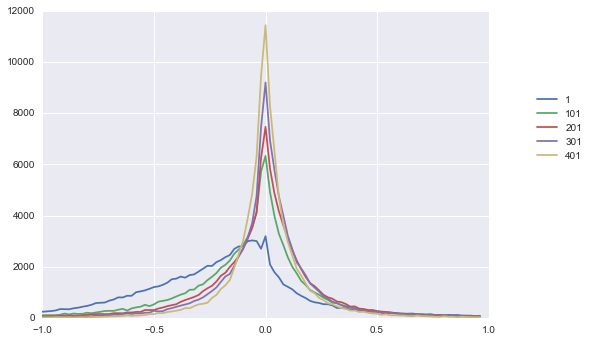

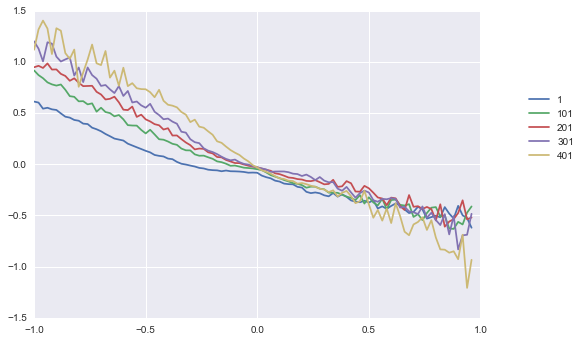

In [14]:
# Try looking at a search on window size for a single window mean.

bins = np.arange(-1, 1, 1/50)

param = 30
search = np.arange(1, 451, 100)

X_train_l = np.log(param + X_train)
means = []
counts = []

for var in search:
    means_df['windmean'] = X_train_l[:, -var:].mean(axis = 1, keepdims = True)
    cut = pd.cut(means_df.windmean - means_df.X_train_lm, bins = bins)

    newcount = means_df.groupby(cut).count().errors_l1
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.errors_l1
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

It seems we have a dependence on our prediction error depending on whether the window mean log is above or below the entire mean log. So, we can create two new features: the positive part of the difference between the window and the entire means, and the negative part. 

In [15]:
windowSize = 30
param = 30

X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

features_train = X_train_l.mean(axis = 1)
window = X_train_l[:, -windowSize:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_train_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_train = np.stack([features_train, newfeature1, newfeature2], axis = -1)

features_valid = X_valid_l.mean(axis = 1)
window = X_valid_l[:, -windowSize:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_valid_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
print(newfeature0.shape)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_valid = np.stack([features_valid, newfeature1, newfeature2], axis = -1)

linear = LinearRegression()
linear.fit(features_train, Y_train_l)
Y_predict_l = linear.predict(features_valid)
Y_predict = -param + np.exp(Y_predict_l)
newsmape = smape(Y_predict + epsilon, Y_valid)
print('smape = ', newsmape)

(47871, 2)
smape =  61.4660704609


1 smape =  62.7431147172 , 4 smape =  61.6571227127 , 7 smape =  61.0400875756 , 10 smape =  61.0931574967 , 13 smape =  61.151408092 , 16 smape =  61.1295019608 , 19 smape =  61.251188426 , 22 smape =  61.2666209564 , 25 smape =  61.4004257667 , 28 smape =  61.3979223464 , 31 smape =  61.5085328059 , 34 smape =  61.5522689779 , 37 smape =  61.5730796374 , 40 smape =  61.6870103562 , 43 smape =  61.7105069826 , 46 smape =  61.8385627698 , 49 smape =  61.8721390184 , 52 smape =  61.9733942965 , 55 smape =  62.0254596038 , 58 smape =  62.063083387 , 61 smape =  62.1405639043 , 64 smape =  62.1473544639 , 67 smape =  62.2503603425 , 70 smape =  62.3703735785 , 73 smape =  62.5012796701 , 76 smape =  62.5551529265 , 79 smape =  62.6024477242 , 82 smape =  62.7252686617 , 85 smape =  62.7433660191 , 88 smape =  62.8001473495 , 91 smape =  62.8309527922 , 94 smape =  62.8788510816 , 97 smape =  62.9299163464 , 

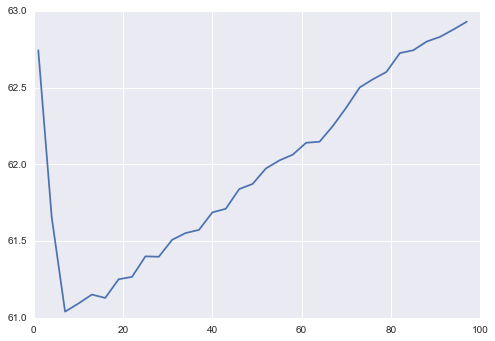

In [16]:
# Now let's try searching over windowSize.

windowSize = 101
param = 30

search = np.arange(1, 100, 3)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

results = []
for var in search:

    features_train = X_train_l.mean(axis = 1)
    window = X_train_l[:, -var:].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_train_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1)
    newfeature2 = np.amin(newfeature0, axis = 1)
    features_train = np.stack([features_train, newfeature1, newfeature2], axis = -1)

    features_valid = X_valid_l.mean(axis = 1)
    window = X_valid_l[:, -var:].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_valid_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1)
    newfeature2 = np.amin(newfeature0, axis = 1)
    features_valid = np.stack([features_valid, newfeature1, newfeature2], axis = -1)

    linear = LinearRegression()
    linear.fit(features_train, Y_train_l)
    Y_predict_l = linear.predict(features_valid)
    Y_predict = -param + np.exp(Y_predict_l)
    newsmape = smape(Y_predict + epsilon, Y_valid)
    print(var, 'smape = ', newsmape, ', ', end = '')
    results.append(newsmape)
    
plt.plot(search, results)
plt.show()

1 smape =  62.4003717409 , 4 smape =  61.6125339163 , 7 smape =  61.0214475217 , 10 smape =  61.0182333767 , 13 smape =  61.0800857269 , 16 smape =  61.069025192 , 19 smape =  61.2231584511 , 22 smape =  61.328882704 , 25 smape =  61.468063202 , 28 smape =  61.4996150748 , 31 smape =  61.6070857164 , 34 smape =  61.6642972535 , 37 smape =  61.691672238 , 40 smape =  61.8154359679 , 43 smape =  61.8667362411 , 46 smape =  62.0092250769 , 49 smape =  62.0532714207 , 52 smape =  62.1606956426 , 55 smape =  62.2438553453 , 58 smape =  62.2938564804 , 61 smape =  62.3816711043 , 64 smape =  62.4037021962 , 67 smape =  62.5253660941 , 70 smape =  62.6821673218 , 73 smape =  62.8661466589 , 76 smape =  62.9490146409 , 79 smape =  63.022458744 , 82 smape =  63.2219652117 , 85 smape =  63.2553078351 , 88 smape =  63.3162588452 , 91 smape =  63.3576846361 , 94 smape =  63.4099769967 , 97 smape =  63.4650146907 , 

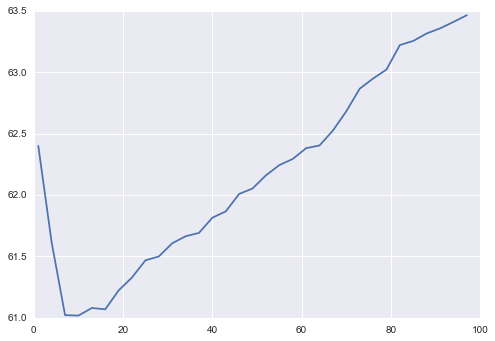

In [17]:
# Now let's try searching over windowSize using quadratic features.

windowSize = 101
param = 30

search = np.arange(1, 100, 3)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

results = []
for var in search:

    features_train = X_train_l.mean(axis = 1, keepdims = True)
    window = X_train_l[:, -var:].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_train_lm
    newfeature1 = newfeature0
    newfeature2 = newfeature0**2
    features_train = np.concatenate([features_train, newfeature1, newfeature2], axis = -1)

    features_valid = X_valid_l.mean(axis = 1, keepdims = True)
    window = X_valid_l[:, -var:].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_valid_lm
    newfeature1 = newfeature0
    newfeature2 = newfeature0**2
    features_valid = np.concatenate([features_valid, newfeature1, newfeature2], axis = -1)

    linear = LinearRegression()
    linear.fit(features_train, Y_train_l)
    Y_predict_l = linear.predict(features_valid)
    Y_predict = -param + np.exp(Y_predict_l)
    newsmape = smape(Y_predict + epsilon, Y_valid)
    print(var, 'smape = ', newsmape, ', ', end = '')
    results.append(newsmape)
    
plt.plot(search, results)
plt.show()

In [18]:
# Let's get the error in our model for an optimal choice of windowSize.

windowSize = 30
param = 30

X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

features_train = X_train_l.mean(axis = 1)
window = X_train_l[:, -windowSize:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_train_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_train = np.stack([features_train, newfeature1, newfeature2], axis = -1)

features_valid = X_valid_l.mean(axis = 1)
window = X_valid_l[:, -windowSize:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_valid_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
print(newfeature0.shape)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_valid = np.stack([features_valid, newfeature1, newfeature2], axis = -1)

linear = LinearRegression()
linear.fit(features_train, Y_train_l)
Y_predict_l = linear.predict(features_valid)
Y_predict = -param + np.exp(Y_predict_l)
newsmape = smape(Y_predict + epsilon, Y_valid)
print('smape = ', newsmape)
print(linear.coef_)

Y_predict_l = linear.predict(features_train)
Y_errors_l2 = Y_predict_l - Y_train_l
means_df['errors_l2'] = (Y_predict_l - Y_train_l).mean(axis = 1)

(47871, 2)
smape =  61.4660704609
[[ 0.9809956   0.8579264   0.9605668 ]
 [ 0.99222703  0.89774737  0.9577322 ]
 [ 0.99745071  0.8288044   0.97863924]
 [ 0.99585104  0.7699206   0.98124771]
 [ 0.99314522  0.72453562  0.98165981]
 [ 0.99225074  0.71944938  0.97511508]
 [ 0.98157015  0.70681811  0.96145062]
 [ 0.97410064  0.73372948  0.93305106]
 [ 0.9984636   0.72901354  0.9259542 ]
 [ 0.99869917  0.66817041  0.95205266]
 [ 0.9927163   0.6511026   0.94901521]
 [ 0.99224457  0.63649008  0.95255009]
 [ 0.98702756  0.62820427  0.94455337]
 [ 0.97814216  0.62925116  0.93719911]
 [ 0.97160127  0.63968248  0.91666826]
 [ 0.98779522  0.66231715  0.86474425]
 [ 0.9909945   0.58824462  0.93953949]
 [ 0.98611701  0.53787726  0.94591963]
 [ 0.98672318  0.53178682  0.92903039]
 [ 0.98524062  0.52813991  0.92367023]
 [ 0.98114136  0.52943107  0.92883058]
 [ 0.97401853  0.55866412  0.90718448]
 [ 0.99201323  0.57372481  0.90033836]
 [ 0.99548384  0.52284546  0.90922936]
 [ 0.98521224  0.49254165  0.9

In [19]:
means_df.head()

,X_train_lm,Y_train_lm,errors_l1,windmean,errors_l2
0,4.543886,4.407597,0.051767,4.647559,0.025181
1,4.581753,4.395935,0.099032,4.695509,0.217343
2,3.764482,4.219276,-0.492731,3.829473,-0.457265
3,7.689277,7.360345,0.056409,7.557451,-0.054483
4,4.747078,4.577913,0.072499,4.728693,0.060129


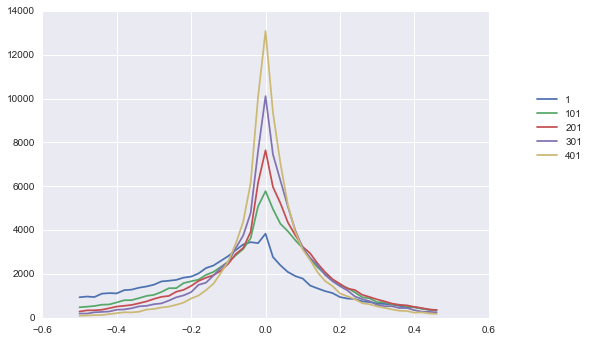

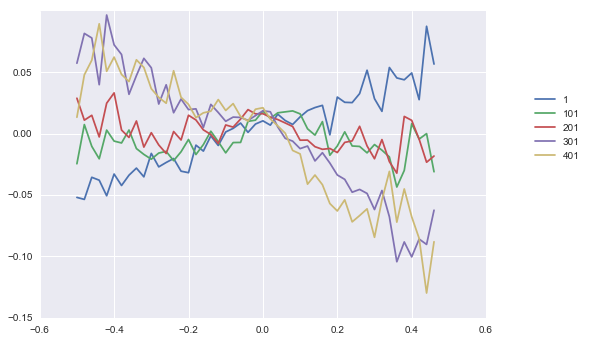

In [20]:
# Try looking at a search on window size for the second window mean.

bins = np.arange(-0.5, 0.5, 1/50)

param = 30
windSize1 = 30
search = np.arange(1, 451, 100)

X_train_l = np.log(param + X_train)
means = []
counts = []

for var in search:
    means_df['windmean2'] = X_train_l[:, -windSize1 - var : -windSize1].mean(axis = 1, keepdims = True)
    cut = pd.cut(means_df.windmean2 - means_df.X_train_lm, bins = bins)

    newcount = means_df.groupby(cut).count().errors_l2
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.errors_l2
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

1   0.476453394498 , 26   0.592330887294 , 51   0.621269916404 , 76   0.654152903948 , 101   0.675564691801 , 126   0.701309885828 , 151   0.731375476635 , 176   0.762342442588 , 201   0.791446787835 , 226   0.821169158509 , 251   0.850992864842 , 276   0.88601816171 , 301   0.927606737066 , 326   0.956876112386 , 351   0.982959335289 , 376   0.988851754196 , 401   0.971064485532 , 426   0.939206626689 , 

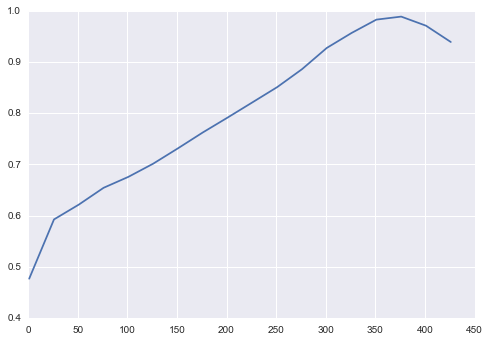

In [21]:
# Try looking at a linear correlations between first window mean and second window mean after adjusting relative to overall
# mean.

bins = np.arange(-1, 1, 1/50)

param = 30
windSize1 = 30
search = np.arange(1, 451, 25)

X_train_l = np.log(param + X_train)
means = []
counts = []

wind1_diff = means_df.windmean - means_df.X_train_lm
results = []
for var in search:
    means_df['windmean2'] = X_train_l[:, -windSize1 - var : -windSize1].mean(axis = 1, keepdims = True)
    wind2_diff = means_df.windmean2 - means_df.X_train_lm
    corr_vars = np.stack([wind1_diff, wind2_diff])
    corr_matrix = np.corrcoef(corr_vars)
    results.append(corr_matrix[0,1])
    print(var, ' ', corr_matrix[0,1], ', ', end = '')
    
plt.plot(search, results)
plt.show()

250 smape =  61.3901886186 , 275 smape =  61.3751390971 , 300 smape =  61.3435194445 , 325 smape =  61.3417311502 , 350 smape =  61.3421236092 , 375 smape =  61.3490734397 , 400 smape =  61.3630315299 , 425 smape =  61.3708485592 , 450 smape =  61.3817871896 , 475 smape =  61.3838819831 , 

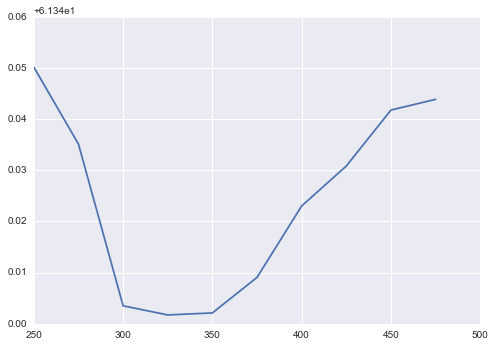

In [22]:
# Let's try searching over second window size for optimal value.

windowSize1 = 30
param = 30

search = np.arange(80, 130, 4)
search = np.arange(250, 500, 25)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

# Get feature for first window mean.

features_train0 = X_train_l.mean(axis = 1)
window = X_train_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_train_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_train0 = np.stack([features_train0, newfeature1, newfeature2], axis = -1)

features_valid0 = X_valid_l.mean(axis = 1)
window = X_valid_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_valid_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_valid0 = np.stack([features_valid0, newfeature1, newfeature2], axis = -1)


results = []
for var in search:

    window = X_train_l[:, -windowSize1 - var : -windowSize1].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_train_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1, keepdims = True)
    newfeature2 = np.amin(newfeature0, axis = 1, keepdims = True)
    features_train = np.concatenate((features_train0, newfeature1, newfeature2), axis = -1)

    window = X_valid_l[:, -windowSize1 - var: -windowSize1].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_valid_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1, keepdims = True)
    newfeature2 = np.amin(newfeature0, axis = 1, keepdims = True)
    features_valid = np.concatenate([features_valid0, newfeature1, newfeature2], axis = -1)

    linear = LinearRegression()
    linear.fit(features_train, Y_train_l)
    Y_predict_l = linear.predict(features_valid)
    Y_predict = -param + np.exp(Y_predict_l)
    newsmape = smape(Y_predict + epsilon, Y_valid)
    print(var, 'smape = ', newsmape, ', ', end = '')
    results.append(newsmape)
    
plt.plot(search, results)
plt.show()

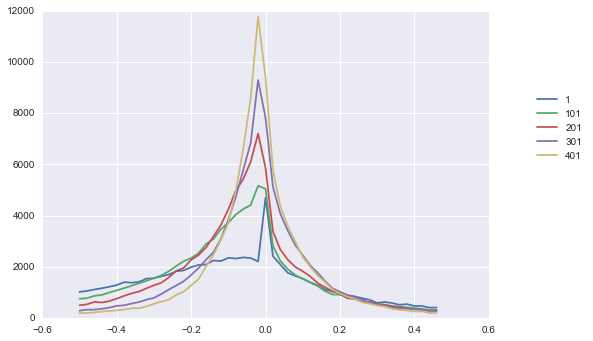

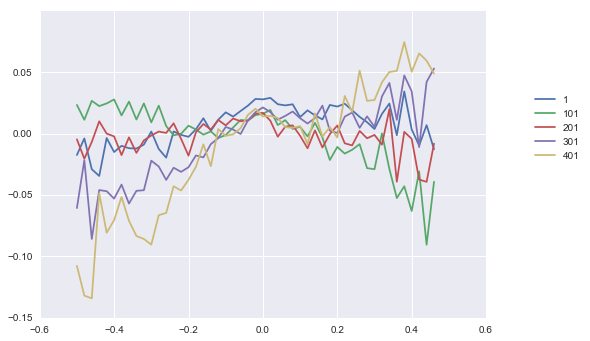

In [23]:
# Try looking at a search on window size at beginning of time.

bins = np.arange(-0.5, 0.5, 1/50)

param = 30
windSize1 = 30
search = np.arange(1, 451, 100)

X_train_l = np.log(param + X_train)
means = []
counts = []

for var in search:
    means_df['windmean3'] = X_train_l[:, : var].mean(axis = 1, keepdims = True)
    cut = pd.cut(means_df.windmean3 - means_df.X_train_lm, bins = bins)

    newcount = means_df.groupby(cut).count().errors_l2
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.errors_l2
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

1 smape =  61.392548468 , 51 smape =  61.442346019 , 101 smape =  61.415391708 , 151 smape =  61.3833593877 , 201 smape =  61.377089466 , 251 smape =  61.3709376018 , 301 smape =  61.3518368821 , 351 smape =  61.3255917992 , 401 smape =  61.3247594851 , 451 smape =  61.3789038065 , 501 smape =  61.3724951958 , 551 smape =  61.3743171351 , 601 smape =  61.3909269608 , 

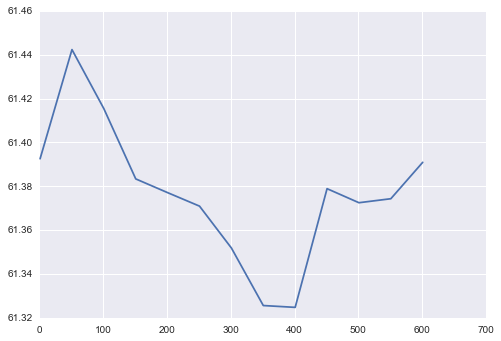

In [24]:
# Let's try searching over second window size at beginning for optimal value.

windowSize1 = 30
param = 30

search = np.arange(80, 130, 4)
search = np.arange(1, 650, 50)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

# Get feature for first window mean.

features_train0 = X_train_l.mean(axis = 1)
window = X_train_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_train_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_train0 = np.stack([features_train0, newfeature1, newfeature2], axis = -1)

features_valid0 = X_valid_l.mean(axis = 1)
window = X_valid_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_valid_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_valid0 = np.stack([features_valid0, newfeature1, newfeature2], axis = -1)


results = []
for var in search:

    window = X_train_l[:, : var].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_train_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1, keepdims = True)
    newfeature2 = np.amin(newfeature0, axis = 1, keepdims = True)
    features_train = np.concatenate((features_train0, newfeature1, newfeature2), axis = -1)

    window = X_valid_l[:, : var].mean(axis = 1, keepdims = True)
    newfeature0 = window - X_valid_lm
    newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    newfeature1 = np.amax(newfeature0, axis = 1, keepdims = True)
    newfeature2 = np.amin(newfeature0, axis = 1, keepdims = True)
    features_valid = np.concatenate((features_valid0, newfeature1, newfeature2), axis = -1)

    linear = LinearRegression()
    linear.fit(features_train, Y_train_l)
    Y_predict_l = linear.predict(features_valid)
    Y_predict = -param + np.exp(Y_predict_l)
    newsmape = smape(Y_predict + epsilon, Y_valid)
    print(var, 'smape = ', newsmape, ', ', end = '')
    results.append(newsmape)
    
plt.plot(search, results)
plt.show()

# Linear Projection

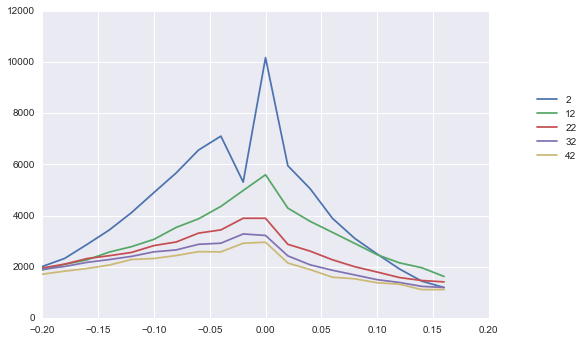

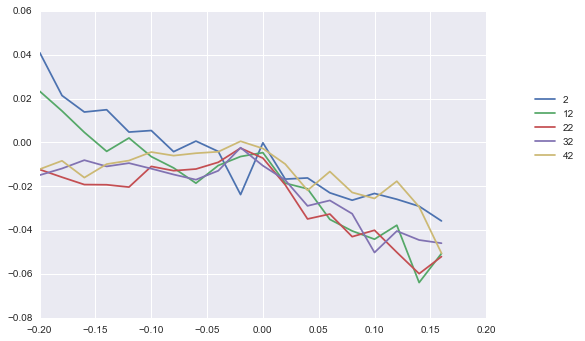

In [25]:
# Try looking at a search on window size at beginning of time.

bins = np.arange(-0.2, 0.2, 1/50)

param = 30
windSize1 = 30
search = np.arange(2, 45, 10)

X_train_l = np.log(param + X_train)
means = []
counts = []

for var in search:
    linear = np.arange(var) - (var - 1) / 2
    linear  /= np.linalg.norm(linear)
    linear_train = np.dot(X_train_l[:, -var:], linear)
    means_df['linear'] = linear_train
    cut = pd.cut(means_df.linear, bins = bins)

    newcount = means_df.groupby(cut).count().errors_l2
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.errors_l2
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

Looks like we can use positive and negative parts of linear projections.

15 smape =  61.1507276604 , 16 smape =  61.0862991623 , 17 smape =  61.0111426036 , 18 smape =  60.9143137511 , 19 smape =  60.8676185811 , 20 smape =  60.8403013438 , 21 smape =  60.8777784294 , 22 smape =  60.8444630254 , 23 smape =  60.8236749235 , 24 smape =  60.7715176539 , 25 smape =  60.7136768414 , 26 smape =  60.7026079485 , 27 smape =  60.7835036084 , 28 smape =  60.8647134527 , 29 smape =  60.8690890462 , 30 smape =  60.8641528115 , 31 smape =  60.8740184271 , 32 smape =  60.9073971427 , 33 smape =  60.9574381201 , 34 smape =  61.0516018018 , 

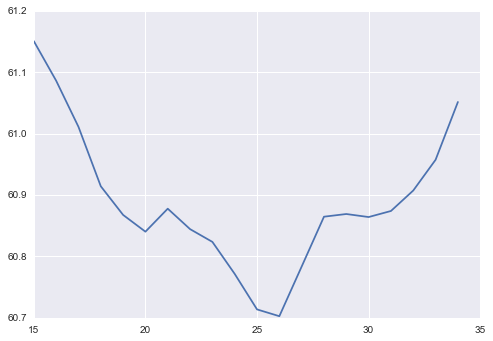

In [26]:
# Let's try searching over second window size at beginning for optimal value.

windowSize1 = 30
param = 30

search = np.arange(80, 130, 4)
search = np.arange(15, 35, 1)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)

# Get feature for first window mean.

features_train0 = X_train_l.mean(axis = 1)
window = X_train_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_train_lm
newfeature0 = np.concatenate((newfeature0 + 0.025, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_train0 = np.stack([features_train0, newfeature1, newfeature2], axis = -1)

features_valid0 = X_valid_l.mean(axis = 1)
window = X_valid_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_valid_lm
newfeature0 = np.concatenate((newfeature0 + 0.025, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_valid0 = np.stack([features_valid0, newfeature1, newfeature2], axis = -1)


results = []
for var in search:

    linear = np.arange(var) - (var - 1) / 2
    linear  /= np.linalg.norm(linear)
    
    linear_train = np.dot(X_train_l[:, -var:], linear).reshape(-1,1)
    newfeature0 = linear_train
    #newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    #newfeature1 = np.amax(newfeature0, axis = 1, keepdims = True)
    #newfeature2 = np.amin(newfeature0, axis = 1, keepdims = True)
    newfeature1 = newfeature0
    newfeature2 = newfeature0**2
    features_train = np.concatenate((features_train0, newfeature1, newfeature2), axis = -1)
    
    linear_valid = np.dot(X_valid_l[:, -var:], linear).reshape(-1,1)
    newfeature0 = linear_valid
    #newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
    #newfeature1 = np.amax(newfeature0, axis = 1, keepdims = True)
    #newfeature2 = np.amin(newfeature0, axis = 1, keepdims = True)
    newfeature1 = newfeature0
    newfeature2 = newfeature0**2
    features_valid = np.concatenate((features_valid0, newfeature1, newfeature2), axis = -1)

    linear = LinearRegression()
    linear.fit(features_train, Y_train_l)
    Y_predict_l = linear.predict(features_valid)
    Y_predict = -param + np.exp(Y_predict_l)
    newsmape = smape(Y_predict + epsilon, Y_valid)
    print(var, 'smape = ', newsmape, ', ', end = '')
    results.append(newsmape)
    
plt.plot(search, results)
plt.show()

In [27]:
(61.46 - 60.70) / 61.46

0.012365766352098894

Perhaps we shouldn't look at distribution of means. Let's look at distributions of linear projections of Y values.

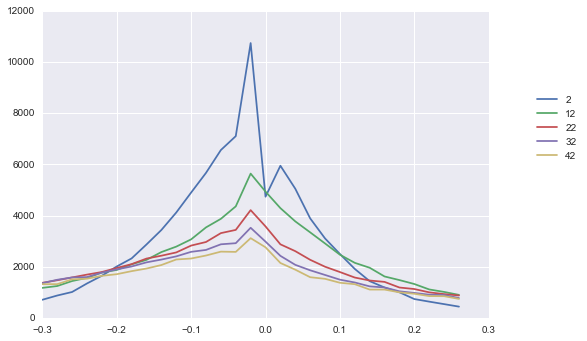

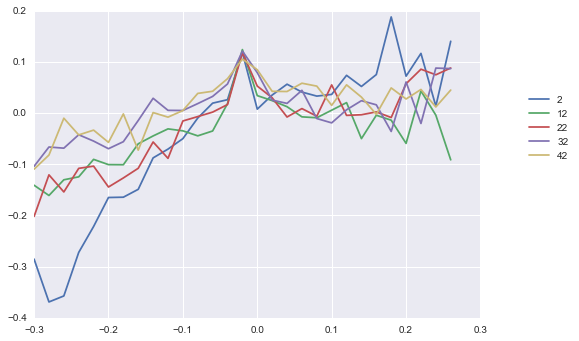

In [28]:
# Try looking at a search on window size at beginning of time.

bins = np.arange(-0.3, 0.3, 1/50)

param = 30
windSize1 = 30
search = np.arange(2, 45, 10)
search = np.arange(2, 50, 10)

nSamples, yTimes = Y_train.shape
linear = np.arange(yTimes) - (yTimes - 1) / 2
linear /= np.linalg.norm(linear)
Y_errors_lin = np.dot(Y_errors_l2, linear)
means_df['Y_errors_lin'] = Y_errors_lin

X_train_l = np.log(param + X_train)
means = []
counts = []

for var in search:
    linear = np.arange(var) - (var - 1) / 2
    linear  /= np.linalg.norm(linear)
    linear_train = np.dot(X_train_l[:, -var:], linear)
    means_df['linear'] = linear_train
    cut = pd.cut(means_df.linear, bins = bins)

    newcount = means_df.groupby(cut).count().Y_errors_lin
    counts.append(newcount)
    grouped_df = means_df.groupby(cut).mean()
    newmean = grouped_df.Y_errors_lin
    means.append(newmean)
    
counts = np.stack(counts, axis = -1)
plt.plot(bins[:-1], counts)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

means = np.stack(means, axis = -1)
plt.plot(bins[:-1], means)
plt.legend(search, loc = (1.1, 0.5))
plt.show()

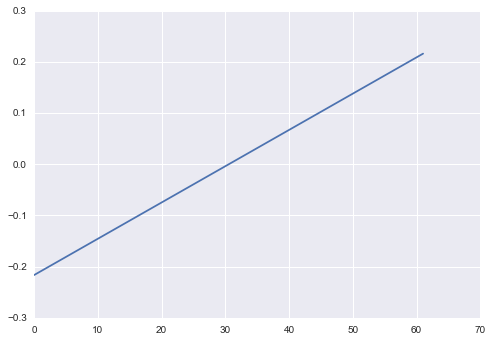

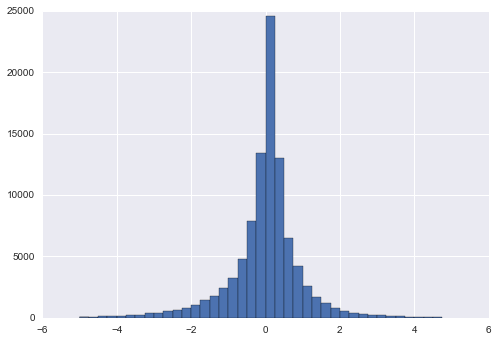

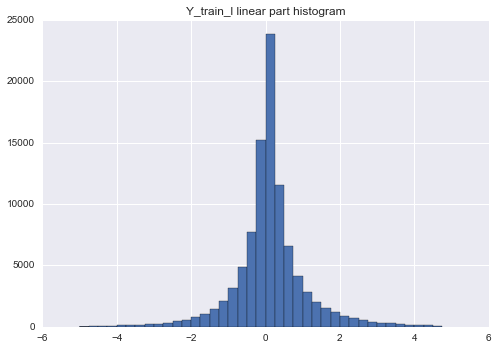

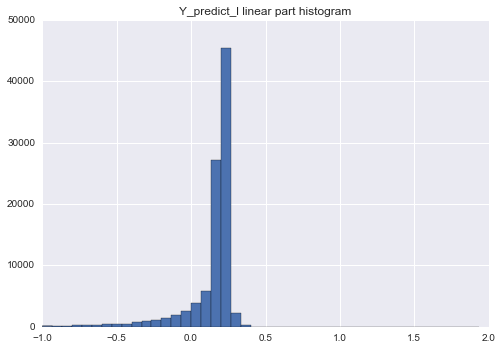

In [29]:
nSamples, yTimes = Y_train.shape
linear = np.arange(yTimes) - (yTimes - 1) / 2
linear /= np.linalg.norm(linear)
Y_train_llin = np.dot(Y_train_l, linear)
Y_errors_lin = np.dot(Y_errors_l2, linear)
means_df['Y_errors_lin'] = Y_errors_lin
means_df['Y_train_llin'] = Y_train_llin

plt.plot(linear)
plt.show()

means_df.Y_errors_lin.hist(bins = np.arange(-5, 5, 5 /  20))
plt.show()

means_df.Y_train_llin.hist(bins = np.arange(-5, 5, 5 / 20))
plt.title('Y_train_l linear part histogram')
plt.show()

(means_df.Y_train_llin + means_df.Y_errors_lin).hist(bins = np.arange(-1, 2, 2 / 30))
plt.title('Y_predict_l linear part histogram')
plt.show()

In [30]:
# Try doing a linear fit of constant and linear parts of target Y.

windowSize1 = 30
param = 30

search = np.arange(80, 130, 4)
search = np.arange(15, 35, 1)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)
Y_train_l = np.log(param + Y_train)

# Get feature for first window mean.

features_train = X_train_l.mean(axis = 1)
window = X_train_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_train_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_train = np.stack([features_train, newfeature1, newfeature2], axis = -1)

features_valid = X_valid_l.mean(axis = 1)
window = X_valid_l[:, -windowSize1:].mean(axis = 1, keepdims = True)
newfeature0 = window - X_valid_lm
newfeature0 = np.concatenate((newfeature0, np.zeros(newfeature0.shape)), axis = -1)
newfeature1 = np.amax(newfeature0, axis = 1)
newfeature2 = np.amin(newfeature0, axis = 1)
features_valid = np.stack([features_valid, newfeature1, newfeature2], axis = -1)

nSamples, xTimes = X_train.shape
xTimes = 62
X_basis = [i for i in range(5)]
for i in range(len(X_basis)):
    X_basis[i] = np.arange(xTimes, dtype = 'float32') **i
    for j in range(i):
        X_basis[i] -= np.dot(X_basis[i], X_basis[j]) * X_basis[j]
    X_basis[i] /= np.linalg.norm(X_basis[i])
X_basis = np.stack(X_basis)
print(X_basis.shape)

newfeatures_train = np.dot(X_train[:, -xTimes : ], X_basis.T)
features_train = np.concatenate((features_train, newfeatures_train), axis = -1)

newfeatures_valid = np.dot(X_valid[:, -xTimes : ], X_basis.T)
features_valid = np.concatenate((features_valid, newfeatures_valid), axis = -1)


nSamples, yTimes = Y_train.shape

basis = [i for i in range(5)]
for i in range(len(basis)):
    basis[i] = np.arange(yTimes, dtype = 'float32')**i
    for j in range(i):
        basis[i] -= np.dot(basis[i], basis[j]) * basis[j]
    basis[i] /= np.linalg.norm(basis[i])
basis = np.stack(basis)
print(basis.shape)
    
Y_train_feat = np.dot(Y_train_l, basis.T)

linear = LinearRegression()
linear.fit(features_train, Y_train_feat)
Y_predict_feat = linear.predict(features_valid)
print(Y_predict_feat.shape)
Y_predict_l = np.dot(Y_predict_feat, basis)
Y_predict = -param + np.exp(Y_predict_l)
newsmape = smape(epsilon + Y_predict, Y_valid)
print('smape = ', newsmape)
print(linear.coef_)

(5, 62)
(5, 62)
(47871, 5)
smape =  61.7404957998
[[  7.74628483e+00   4.12509899e+00   7.34192649e+00   4.23690504e-07
    4.14646105e-06   2.04688260e-05   1.94573709e-05   9.64042936e-06]
 [ -1.64403108e-02  -1.01303521e+00  -7.74658363e-02  -4.16014329e-07
   -3.39376978e-06  -9.61128392e-06  -9.60862446e-06  -5.14927162e-06]
 [  1.76579576e-02   3.84730352e-01  -1.46237271e-02   1.63753423e-07
    1.34632313e-06   5.37021450e-06   4.67253991e-06   3.17072150e-06]
 [  1.22451625e-02  -7.07578475e-02  -1.72629009e-01  -5.27098384e-08
   -3.66038302e-07  -2.16659890e-06  -1.97773791e-06  -1.65468794e-06]
 [  1.01927459e-02   7.61920842e-02  -9.97806500e-02   1.15313798e-08
    2.37114305e-07   9.40745113e-07  -2.97463944e-07  -2.01001398e-07]]


In [261]:
def polybasis(nTimes, degree):
    basis = []
    for i in range(degree + 1):
        basis.append(np.arange(nTimes, dtype = 'float32')**i)
        for j in range(i):
            basis[i] -= np.dot(basis[i], basis[j]) * basis[j]
        basis[i] /= np.linalg.norm(basis[i])
        
    basis = np.stack(basis)
    return basis

def polyfeatures(X, windowSize, degree):
    
    nSamples, nTimes = X.shape
    
    # Construct orthonormal polynomial basis.
    
    all_basis = polybasis(nTimes, degree)
    all_features = np.dot(X, all_basis.T)
    
    wind_basis = polybasis(windowSize, degree)
    wind_features = np.dot(X[:, -windowSize:], wind_basis.T)
    all_to_wind = np.dot(all_features, all_basis)[:, -windowSize:]
    all_to_wind = np.dot(all_to_wind, wind_basis.T)
    wind_features -= all_to_wind
    threshold = np.zeros(wind_features.shape)
    wind_features = np.stack([wind_features, threshold])
    wind_positive = np.amax(wind_features, axis = 0)
    wind_negative = np.amin(wind_features, axis = 0)
    
    features = np.concatenate([all_features, wind_positive, wind_negative], axis = -1)
    return features

def polyfeatures_nosplit(X, windowSize, degree):
    
    nSamples, nTimes = X.shape
    
    # Construct orthonormal polynomial basis.
    
    all_basis = polybasis(nTimes, degree)
    all_features = np.dot(X, all_basis.T)
    
    wind_basis = polybasis(windowSize, degree)
    wind_features = np.dot(X[:, -windowSize:], wind_basis.T)
    all_to_wind = np.dot(all_features, all_basis)[:, -windowSize:]
    all_to_wind = np.dot(all_to_wind, wind_basis.T)
    wind_features -= all_to_wind
    
    features = np.concatenate([all_features, wind_features], axis = -1)
    return features
    
print(polyfeatures(X_train, 30, 3).shape)

(97192, 12)


In [266]:
# Try doing a linear fit of constant and linear parts of target Y.

windowSize = 30
degree = 5
param = 30

search = np.arange(80, 130, 4)
search = np.arange(15, 35, 1)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)
Y_train_l = np.log(param + Y_train)

X_train_feat = polyfeatures(X_train_l, windowSize, degree)
X_valid_feat = polyfeatures(X_valid_l, windowSize, degree)
nSamples, yTimes = Y_train_l.shape
Y_basis = polybasis(yTimes, degree)
Y_train_poly = np.dot(Y_train_l, Y_basis.T)

linear = LinearRegression()
linear.fit(X_train_feat, Y_train_poly)
Y_predict_poly = linear.predict(X_valid_feat)
Y_predict_l = np.dot(Y_predict_poly, Y_basis)
Y_predict = -param + np.exp(Y_predict_l)
newsmape = smape(Y_predict + epsilon, Y_valid)
print('smape = ', newsmape)

Y_predict_poly = linear.predict(X_train_feat)
Y_error_poly = Y_predict_poly - Y_train_poly
print(Y_error_poly.shape)

smape =  60.9939506542
(97192, 6)


In [264]:
# Try doing a linear fit of constant and linear parts of target Y.

windowSize = 30
degree = 6
param = 30

search = np.arange(80, 130, 4)
search = np.arange(15, 35, 1)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)
Y_train_l = np.log(param + Y_train)

X_train_feat = polyfeatures_nosplit(X_train_l, windowSize, degree)
X_valid_feat = polyfeatures_nosplit(X_valid_l, windowSize, degree)
nSamples, yTimes = Y_train_l.shape
Y_basis = polybasis(yTimes, degree)
Y_train_poly = np.dot(Y_train_l, Y_basis.T)

tree = DecisionTreeRegressor(max_depth = 13)
tree.fit(X_train_feat, Y_train_poly)
Y_predict_poly = tree.predict(X_valid_feat)
Y_predict_l = np.dot(Y_predict_poly, Y_basis)
Y_predict = -param + np.exp(Y_predict_l)
newsmape = smape(Y_predict + epsilon, Y_valid)
print('smape = ', newsmape)

Y_predict_poly = tree.predict(X_train_feat)
Y_error_poly = Y_predict_poly - Y_train_poly
print(Y_error_poly.shape)

smape =  64.8964659165
(97192, 7)


In [215]:
# Try doing a linear fit of constant and linear parts of target Y.

windowSize = 30
degree = 5
param = 30

search = np.arange(80, 130, 4)
search = np.arange(15, 35, 1)
X_train_l = np.log(param + X_train)
X_valid_l = np.log(param + X_valid)
Y_train_l = np.log(param + Y_train)

X_train_feat = polyfeatures(X_train_l, windowSize, degree)
X_valid_feat = polyfeatures(X_valid_l, windowSize, degree)


linear = LinearRegression()
linear.fit(X_train_feat, Y_train_l)
Y_predict_l = linear.predict(X_valid_feat)
Y_predict = -param + np.exp(Y_predict_l)
newsmape = smape(Y_predict + epsilon, Y_valid)
print('smape = ', newsmape)

smape =  60.5580137197


In [252]:
Y_names = ['Ypoly' + str(i) for i in range(degree + 1)]
X_names = [name + str(i) for name in ['Xall', 'Xpos', 'Xneg'] for i in range(degree + 1)]
print(X_train_feat.shape, Y_train_poly.shape)
means_df = pd.DataFrame(np.concatenate([X_train_feat, Y_train_poly], axis = -1), columns = X_names + Y_names)

error_names = ['error_poly' + str(i) for i in range(degree + 1)]
for i in range(degree + 1):
    means_df['error_poly' + str(i)] = Y_error_poly[:, i]
    
means_df.head()

(97192, 18) (97192, 6)


,Xall0,Xall1,Xall2,Xall3,Xall4,Xall5,Xpos0,Xpos1,Xpos2,Xpos3,...,Ypoly2,Ypoly3,Ypoly4,Ypoly5,error_poly0,error_poly1,error_poly2,error_poly3,error_poly4,error_poly5
0,122.853100,5.001468,-8.171537,2.928661,-1.486313,-2.304059,0.969141,0.000000,0.240297,0.343045,...,0.613680,-0.620160,0.046308,-0.216638,-0.180412,0.357781,-0.449842,0.334317,-0.039309,0.161532
1,123.876897,4.833021,1.643449,-0.904778,-3.030388,-2.461746,0.270276,0.488075,0.000000,0.000000,...,0.564719,-0.030169,0.170167,0.203292,3.528056,1.191719,-0.401260,-0.131891,-0.148884,0.007694
2,101.780335,1.444393,-0.196474,-1.078643,0.446125,-0.152043,0.000000,0.000000,0.000000,0.049651,...,-1.499212,-2.123113,-1.260219,-0.100756,-3.466541,-2.115397,1.583656,2.080563,1.161686,0.112703
3,207.895078,-4.460846,-0.715515,0.947089,2.137312,-3.719764,0.000000,0.308906,0.000000,0.066574,...,-0.044708,-0.073493,0.052305,-0.149132,0.818149,-0.444120,0.083725,0.139056,-0.015467,0.157011
4,128.346817,-0.597852,-1.343062,-0.216970,-0.394017,0.223934,0.199333,0.115641,0.103167,0.000000,...,0.187597,0.031108,0.028935,-0.043915,0.453722,0.229785,-0.257713,-0.045124,-0.022410,0.141075


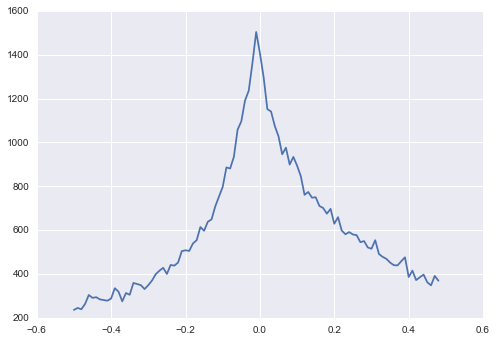

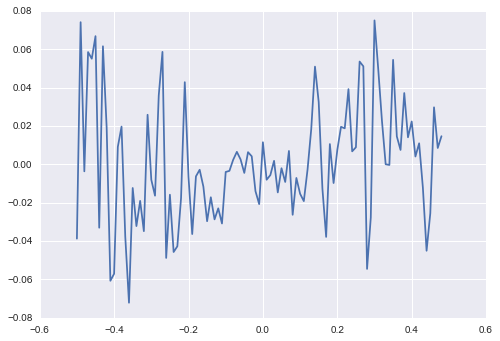

In [257]:
bins = np.arange(-0.5, 0.5, .01)
cut = pd.cut(means_df.Xpos0 + means_df.Xneg0, bins = bins)

grouped_df = means_df.groupby(cut).count()
plt.plot(bins[:-1], grouped_df.Ypoly0. values)
plt.show()

grouped_df = means_df.groupby(cut).mean()
plt.plot(bins[:-1], grouped_df.error_poly3.values)
plt.show()

In [267]:
(61.46 - 60.6) / 61.46

0.013992840872111932